In [1]:
##################################
#                                #
# regression2.ipynb               #
# Created 2022-07-10             #
# Akhil Garg, akhil@akhilgarg.ca #
#                                #
##################################

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import pipeline
from sklearn import linear_model
from sklearn import metrics

import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
data = pd.read_excel('AMR_imputation_6.xlsx').drop('#',axis='columns')

In [27]:
# Only keep data prior to a change in the micro lab reporting system
data2019 = data[data['Episode'] <= 7217]

# List of output antibiotics
output_antibiotics = ['Penicillin_FINAL_imp','Amoxiclav_FINAL_imp','Ampicillin_FINAL_imp','Cloxacillin_FINAL_imp','Piptaz_FINAL_imp','Cefazolin_FINAL_imp','Ceftriaxone_FINAL_imp','Ceftazidime_FINAL_imp','Ertapenem_FINAL_imp','Meropenem_FINAL_imp','Ciprofloxacin_FINAL_imp','Levofloxacin_FINAL_imp','Moxifloxacin_FINAL_imp','Daptomycin_FINAL_imp','Vancomycin_FINAL_imp','Linezolid_FINAL_imp','Amikacin_FINAL_imp','Tobramycin_FINAL_imp','Gentamicin_FINAL_imp','Clindamycin_FINAL_imp','Doxycycline_FINAL_imp','Erythromycin_FINAL_imp','TMPSMX_FINAL_imp']

# Missingness susceptibilities for each antibiotic
print('Missingness')
for abx in output_antibiotics:
    missingness = data2019[data2019[abx]=='no_data'].shape[0] / data2019.shape[0]
    print('{:<15} {:>6.2f}%'.format(abx.split('_')[0],missingness*100))
    
# Piperacillin-tazobactam or tobramycin missingness
data2019[(data2019['Piptaz_FINAL_imp']=='no_data')|(data2019['Tobramycin_FINAL_imp']=='no_data')].shape[0]/data2019.shape[0]*100

Missingness
Penicillin        2.42%
Amoxiclav        35.25%
Ampicillin        1.01%
Cloxacillin       6.52%
Piptaz            1.28%
Cefazolin         1.44%
Ceftriaxone       0.54%
Ceftazidime       0.87%
Ertapenem         1.58%
Meropenem         0.50%
Ciprofloxacin     1.31%
Levofloxacin     16.67%
Moxifloxacin      4.67%
Daptomycin        1.85%
Vancomycin        1.85%
Linezolid         1.85%
Amikacin          2.35%
Tobramycin        0.64%
Gentamicin        0.60%
Clindamycin       4.37%
Doxycycline      80.85%
Erythromycin     55.31%
TMPSMX            0.57%


1.3776881720430108

## Preprocessing

In [4]:
# Change missing data to be resistant
data2019[output_antibiotics] = data2019[output_antibiotics].replace('no_data','RESISTANT')

# Convert susceptible/intermediate/resistant to numerical categorical values
data2019 = data2019.replace({'SUSCEPTIBLE':0,'INTERMEDIATE':1,'RESISTANT':1})

# Create categorical variable columns
# Encode ages as integer variables
ages = {'<40':1, '40-45':2, '45-50':3, '50-55':4, '55-60':5, '60-65':6, 
        '65-70':7, '70-75':8, '75-80':9, '80-85':10, '85-90':11, '>90':12}
data2019['Age'] = data2019['AgeCat'].map(ages)

# Encode sex as male=0, female=1
sexes = {'M':0,'F':1}
data2019['SexCat'] = data2019['Sex'].map(sexes)
data2019

# Change medical vs. surgical admitting service from 1/2 to 0/1
data['Medical(1) Surgical (2) Admitting Service'] = data['Medical(1) Surgical (2) Admitting Service'].replace({1:0,2:1})
data = data.rename({'Medical(1) Surgical (2) Admitting Service':'MedVsSurgAdmission'},axis=1)

# Encode culture type
culture_types = {'BLDC':1,'URCR':2,'BCPOS':1,'CSFCS':3,'URCC':2,
                 'FLDC':3,'BONEC':3,'BXTC' :3,'EARC':3,'FLDBC':3,
                 'FUNC':3,'GMISC':3,'DIALC':3,'INCC':3,'LRESC':3,
                 'ORCU':3,'STCS' :3,'TDRNC':3,'VTIPC':3}
data2019['CultureSource'] = data2019['culture_test_cd'].map(culture_types)

# Create new categories of "prior non-[antibiotic class]"
data2019['PriorNonCephalosporin'] = data2019[['PriorAMG','PriorCarbapenem','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
data2019['PriorNonCarbapenem'] = data2019[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
data2019['PriorNonPenicillin'] = data2019[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
data2019['PriorNonFQ'] = data2019[['PriorAMG','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
data2019['PriorNonAMG'] = data2019[['PriorFQ','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
data2019['PriorNonOtherAbx'] = data2019[['PriorFQ','PriorAMG','PriorCephalosporin','PriorPenicillin','PriorCarbapenem']].any(axis='columns')

# Converts True/False into 1/0
data2019['PriorNonCephalosporin'] = data2019['PriorNonCephalosporin'].apply(int)
data2019['PriorNonCarbapenem']    = data2019['PriorNonCarbapenem'].apply(int)
data2019['PriorNonPenicillin']    = data2019['PriorNonPenicillin'].apply(int)
data2019['PriorNonFQ']            = data2019['PriorNonFQ'].apply(int)
data2019['PriorNonAMG']           = data2019['PriorNonAMG'].apply(int)
data2019['PriorNonOtherAbx']      = data2019['PriorNonOtherAbx'].apply(int)

data2019 = data2019.drop(['MRSA12months','VRE12months','ESBL12months','MRSA7days','VRE7days','ESBL7days',
                          'NumberOfBacteremiasLastYear','ClincalMRSA','ClinicalVRE'],axis=1,errors='ignore')
data2019

,Anonymous_ID,Episode,AgeCat,Sex,YearOfAdmission,Medical(1) Surgical (2) Admitting Service,ClinicalESBL,RecentHospitalization,ICUExposure,PriorAMG,...,TMPSMX_PGNO_imp,Age,SexCat,CultureSource,PriorNonCephalosporin,PriorNonCarbapenem,PriorNonPenicillin,PriorNonFQ,PriorNonAMG,PriorNonOtherAbx
0,1,1,85-90,M,2008,1,0,0,0,0,...,NaN,11,0,2,1,1,0,1,1,1
1,1,2,85-90,M,2008,1,0,0,0,0,...,0.00,11,0,2,1,1,1,1,1,1
2,2,9,>90,M,2011,1,0,0,0,0,...,NaN,12,0,2,0,0,0,0,0,0
3,3,15,>90,M,2012,1,0,0,0,0,...,NaN,12,0,2,0,0,0,0,0,0
4,4,25,45-50,F,2013,1,0,0,0,0,...,NaN,3,1,2,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,2313,7212,60-65,M,2019,1,0,0,0,0,...,NaN,6,0,2,0,0,0,0,0,0
2972,2314,7215,75-80,M,2019,1,0,1,0,0,...,NaN,9,0,1,0,0,0,0,0,0
2973,2314,7215,75-80,M,2019,1,0,1,0,0,...,NaN,9,0,2,0,0,0,0,0,0
2974,2314,7216,75-80,M,2019,1,0,1,1,0,...,1.00,9,0,1,1,1,1,1,1,1


In [5]:
# List of antibiotics to run regression on
antibiotic_list = ['Cefazolin','Ceftriaxone','Ceftazidime','Piptaz','Meropenem','Ciprofloxacin','Tobramycin','TMPSMX']
antibiotic_classes = {'Cefazolin':'Cephalosporin','Ceftriaxone':'Cephalosporin','Ceftazidime':'Cephalosporin',
                      'Piptaz':'Penicillin','Meropenem':'Carbapenem','Ciprofloxacin':'FQ','Tobramycin':'AMG',
                      'TMPSMX':'OtherAbx'}

# Regression Function

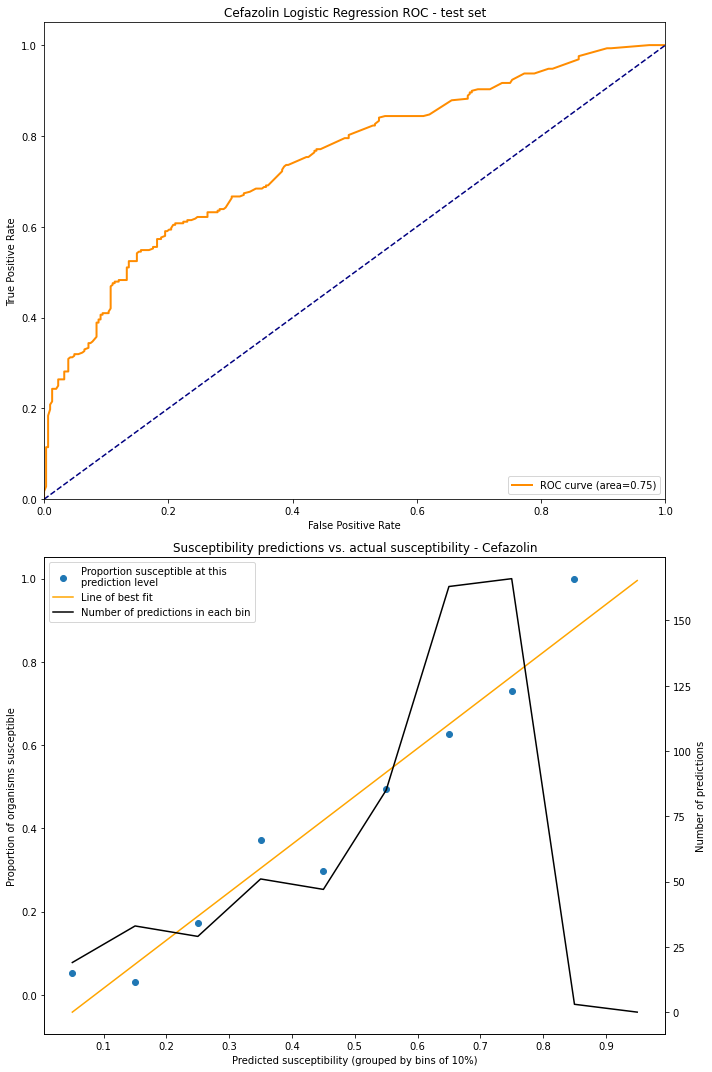

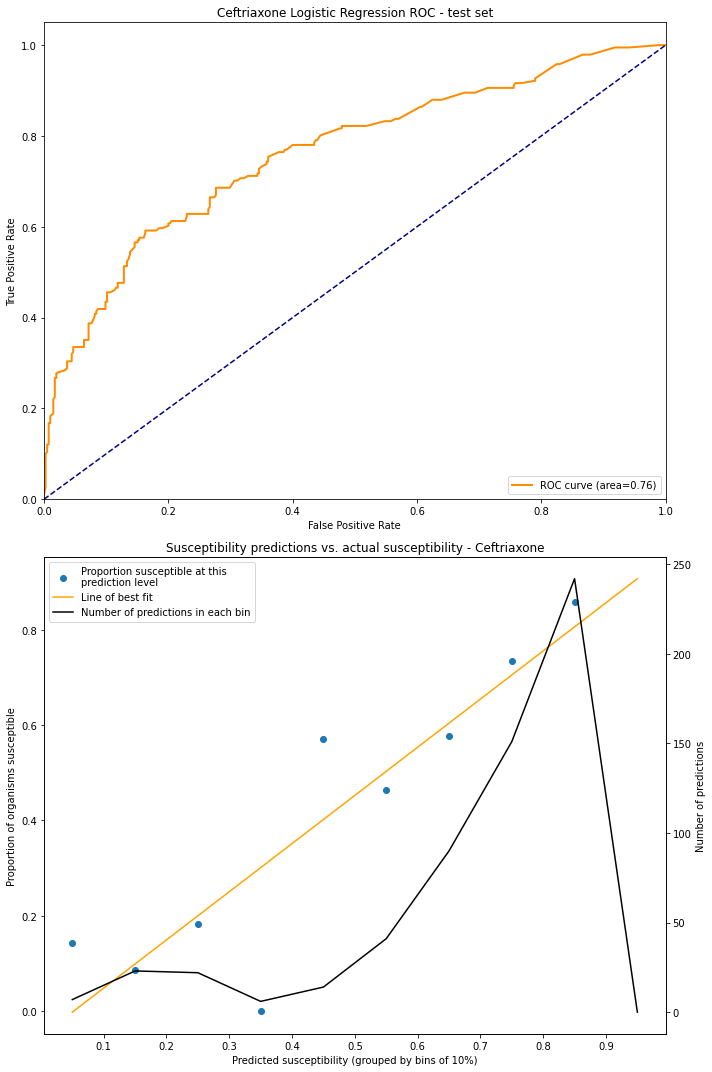

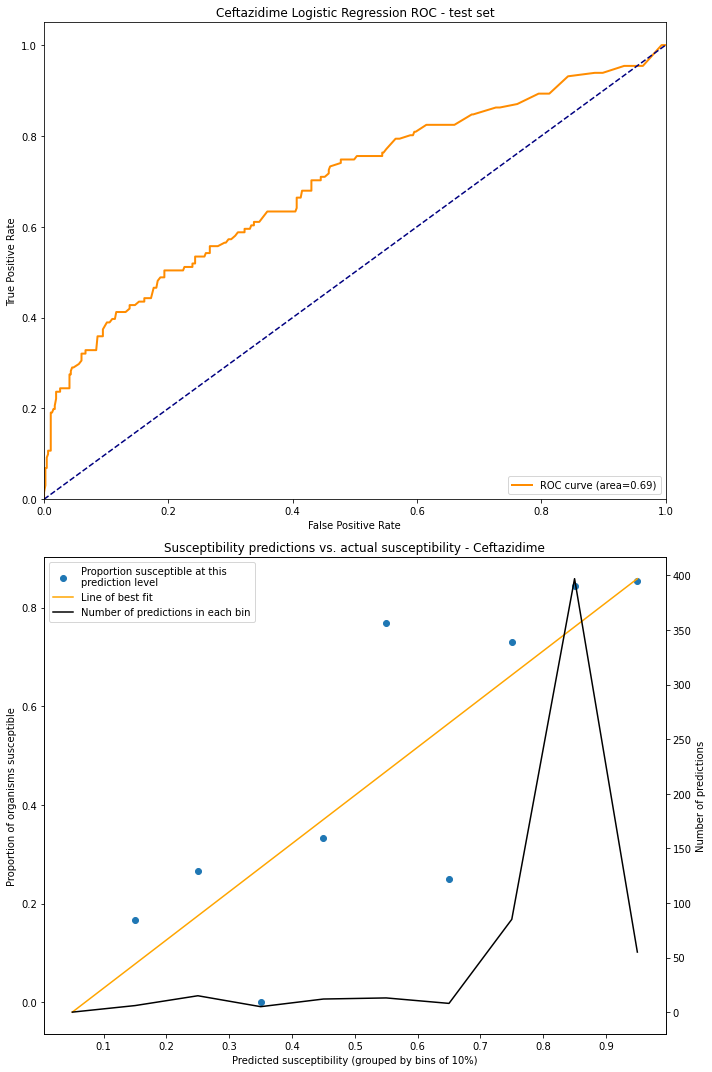

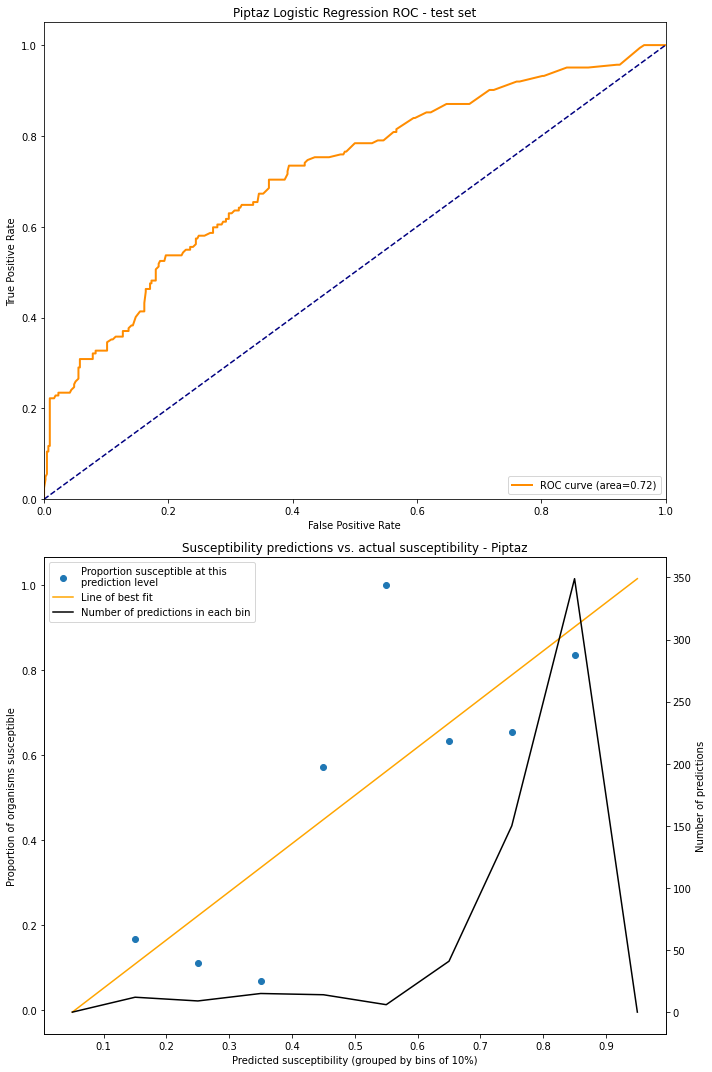

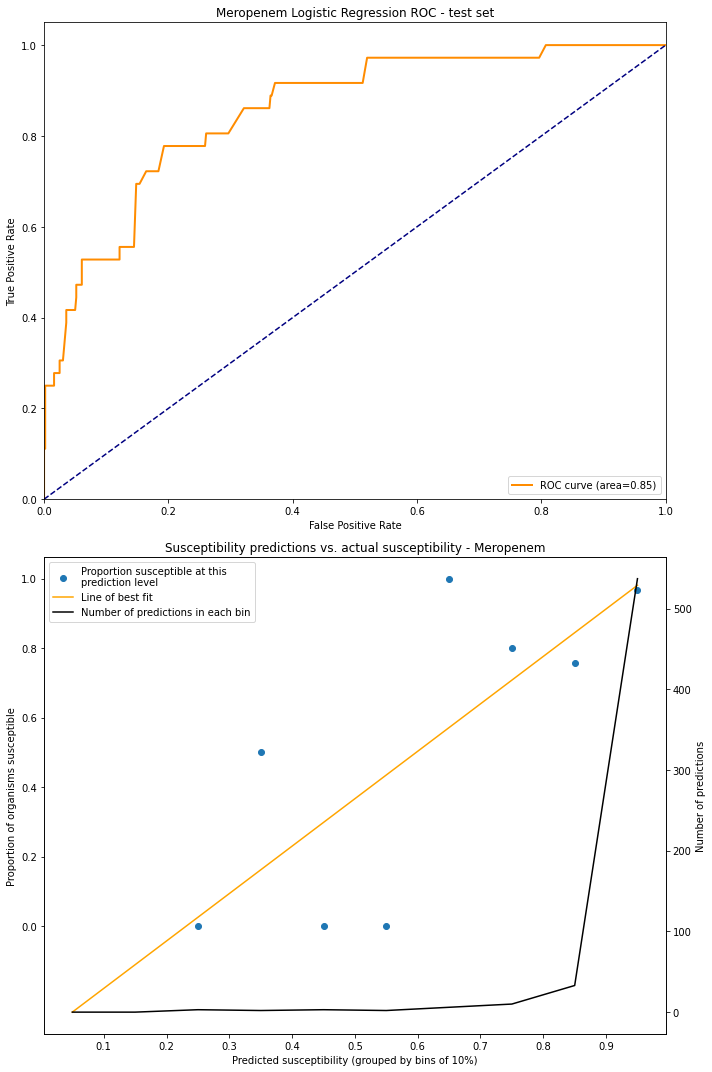

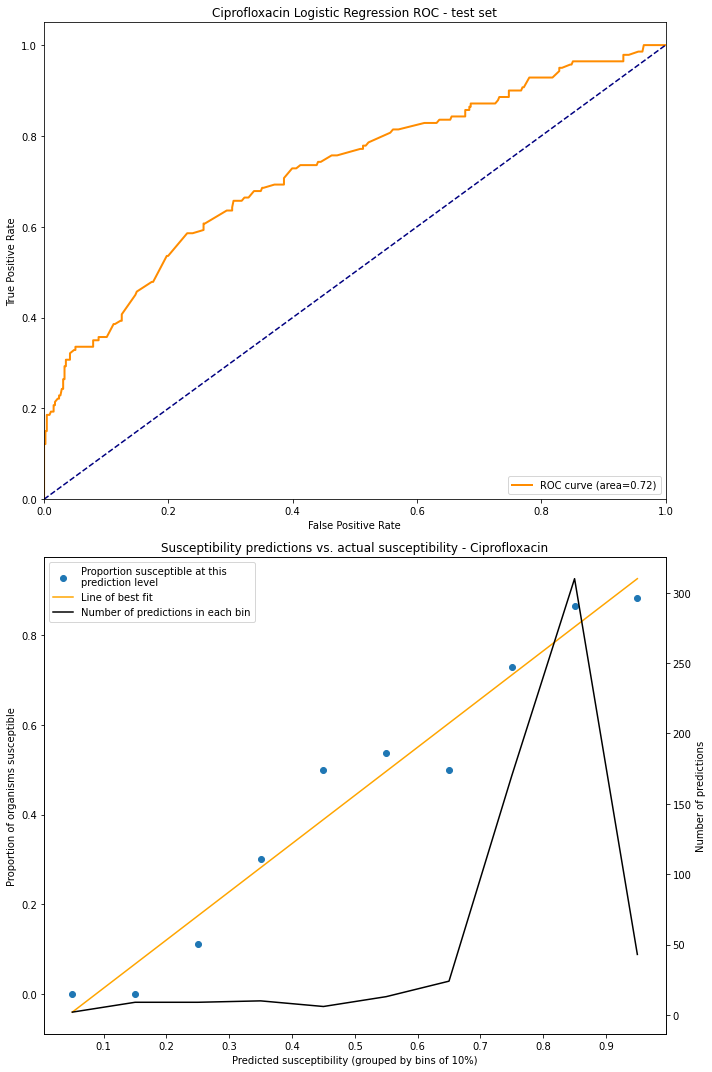

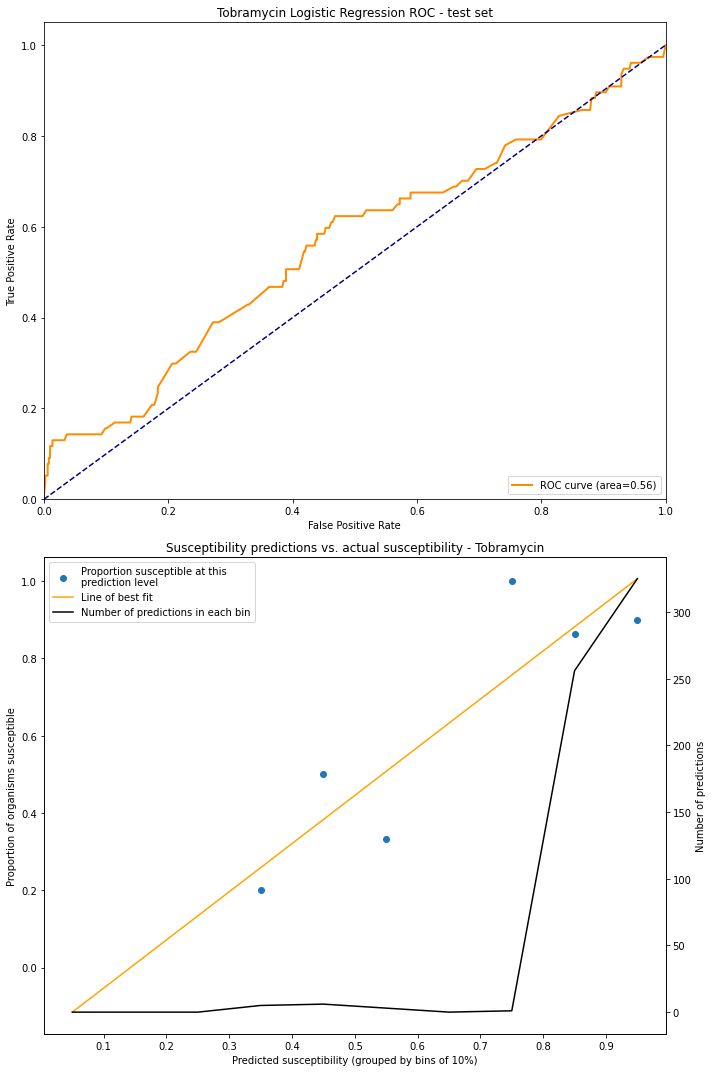

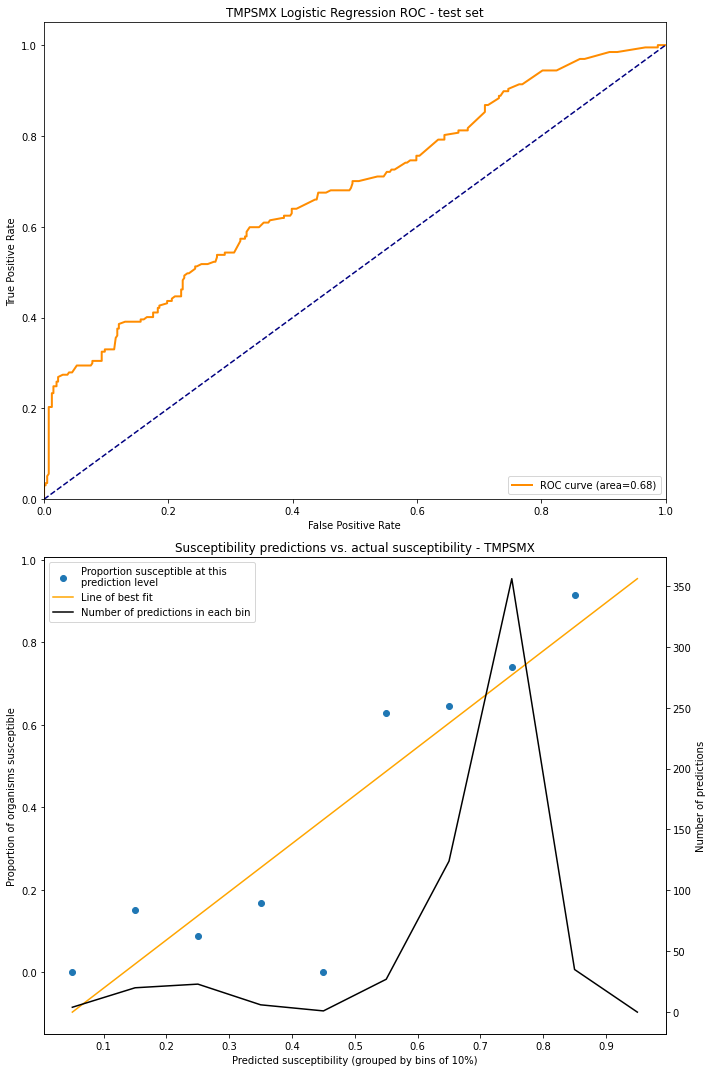

In [6]:
# Look for antibiotic resistance during previous gram negative infection
def previous_infection(priorGNOrg,prior_susceptibility):
    '''
    For a given antibiotic, takes a previous gram negative organism and its susceptibility as input
    Outputs:
        0 if no previous gram negative organism
        0 if previous susceptible gram negative organism
        1 if previous resistant gram negative organism
        1 if previous gram negative organism without susceptibility data
    '''
    
    if priorGNOrg=='no_data': return 0
    elif prior_susceptibility=='no_data': 
        return 1
    else: return prior_susceptibility


def antibiotic_susceptibility_regression(antibiotic):
       
    # Add a column for previous susceptibility to the particular antibiotic
    data2019['PriorGNresistance'] = data2019.apply(lambda x: previous_infection(x['PriorGNOrg'],x[antibiotic+'_PGNO_imp']), axis=1)
    
    regression_inputs = ['Age','SexCat','Medical(1) Surgical (2) Admitting Service','ClinicalESBL',
                         'RecentHospitalization','ICUExposure','PriorGNresistance',
                         'Prior'+antibiotic_classes[antibiotic],'PriorNon'+antibiotic_classes[antibiotic]]
        
    # Divide data into temporal 80-20 train-test sets
    train_set, test_set= np.split(data2019, [int(.8 *len(data2019))])

    X_train = train_set[regression_inputs]
    X_test  = test_set [regression_inputs]
    Y_train = train_set[antibiotic+'_FINAL_imp']
    Y_test  = test_set [antibiotic+'_FINAL_imp']
        
    reg = linear_model.LogisticRegression()
    reg.fit(X_train,Y_train)

    
    # Zip together prediction values and actual test values
    # Then sort by susceptible strains first, followed by prediction values
    predict_results = sorted((zip(reg.predict_proba(X_test)[:,0],Y_test)),key=lambda x:(x[1],x[0]))
    # If one wanted to use the decision function rather than the predicted probability
    # predict_results = sorted((zip(reg.decision_function(X_test),Y_test)),key=lambda x:(x[1],x[0]))

    # Separate out predictions on susceptible and resistant isolates
    susceptible_isolates = []
    resistant_isolates   = []
    for i in predict_results:
        if i[1]==1:
            resistant_isolates.append(i[0])
        else: susceptible_isolates.append(i[0])

            
    # Generate plots
    fig, ax = plt.subplots(nrows=2, figsize=(10,15))
        
    # Calculate and plot ROC based on training set
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,reg.decision_function(X_test))
    AUC = metrics.roc_auc_score(Y_test,reg.decision_function(X_test))
    ax[0].plot(fpr, tpr, color="darkorange", lw=2,
        label="ROC curve (area={:.2})".format(AUC))

    ax[0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].xaxis.set_tick_params(labelbottom=True)    
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].set_title("{} Logistic Regression ROC - test set".format(antibiotic))
    ax[0].legend(loc="lower right")

    
   # First, obtain raw prediction or decision function values to create bins
    probability_list = [x[0] for x in predict_results]

    # Create bins of 0.1 each for later plotting
    hist_edges = np.arange(0,1.05,0.1)
    bin_medians = np.arange(0.05,1.05,0.1)
    bin_susceptibilities = []
    bin_counts = [0]*len(bin_medians)
    
    # Then, loop over bins
    for i in range(len(hist_edges)-1):
        
        # Count the number of susceptible and resistant predictions in each bin
        susceptible_number = 0
        resistant_number = 0        
        for j in predict_results:
            if j[0]>=hist_edges[i] and j[0]<hist_edges[i+1]:
                if j[1] == 0: susceptible_number +=1
                if j[1] == 1: resistant_number   +=1
                bin_counts[i] += 1
                
        # Print and plot observations for each bin
        try:
            percent_susceptible = susceptible_number/(resistant_number+susceptible_number)            
            bin_susceptibilities.append(percent_susceptible)
            
        except ZeroDivisionError:
            bin_susceptibilities.append(np.nan)
    

    # Plot a scatterplot of binned probabilities and actual susceptibility rates in each bin
    ax2a = ax[1]
    ax2b = ax[1].twinx()
    
    ax2a.set_title('Susceptibility predictions vs. actual susceptibility - {}'.format(antibiotic))
    ax2a.set_xlabel('Predicted susceptibility (grouped by bins of 10%)')
    ax2a.set_xticks(np.arange(0,1.1,0.1))
    ax2a.set_ylabel('Proportion of organisms susceptible')

    # Create a bar chart
    ax2b.plot(bin_medians,bin_counts,color='black',label='Number of predictions in each bin')
    ax2b.set_ylabel('Number of predictions')
    
    # Create a scatter plot
    bin_susceptibilities = np.array(bin_susceptibilities)
    ax2a.scatter(bin_medians,bin_susceptibilities,color='C0',label='Proportion susceptible at this\nprediction level')
    ax2a.set_yticks(np.arange(0,1.1,0.2))    
        
    # Create a line of best fit
    non_nan_indices = np.isfinite(bin_medians) & np.isfinite(bin_susceptibilities)
    m,b = np.polyfit(bin_medians[non_nan_indices], bin_susceptibilities[non_nan_indices], 1)
    ax2a.plot(bin_medians,m*bin_medians+b,c='orange',label='Line of best fit')    
    
    # Create a legend
    lines, labels = ax2a.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2a.legend(lines + lines2, labels + labels2, loc='upper left')
    
    # Delete the bottom right graph and plot the others
    plt.tight_layout()
    plt.show()
    
    
for antibiotic in antibiotic_list:
    antibiotic_susceptibility_regression(antibiotic)

In [7]:
# Mean predicted susceptibility of each antibiotic
print('Mean predicted susceptibility of each analyzed antibiotic\n')
print('{:<15} {:<7}'.format('Antibiotic','Prob S'))

for antibiotic in antibiotic_list:

    data2019['PriorGNresistance'] = data2019.apply(lambda x: previous_infection(x['PriorGNOrg'],x[antibiotic+'_PGNO_imp']), axis=1)

    regression_inputs = ['Age','SexCat','Medical(1) Surgical (2) Admitting Service','ClinicalESBL',
                         'RecentHospitalization','ICUExposure','PriorGNresistance',
                         'Prior'+antibiotic_classes[antibiotic],'PriorNon'+antibiotic_classes[antibiotic]]

    # Divide data into 80-20 train-test sets
    train_set, test_set= np.split(data2019, [int(.8 *len(data2019))])

    X_train = train_set[regression_inputs]
    X_test  = test_set [regression_inputs]
    Y_train = train_set[antibiotic+'_FINAL_imp']
    Y_test  = test_set [antibiotic+'_FINAL_imp']

    reg = linear_model.LogisticRegression()
    reg.fit(X_train,Y_train)
    
    print('{:<15} {:>6.2f}'.format(antibiotic, np.mean(reg.predict_proba(X_test)[:,0])))

Mean predicted susceptibility of each analyzed antibiotic

Antibiotic      Prob S 
Cefazolin         0.56
Ceftriaxone       0.70
Ceftazidime       0.81
Piptaz            0.77
Meropenem         0.95
Ciprofloxacin     0.78
Tobramycin        0.90
TMPSMX            0.68


Mean susceptibility: 0.93


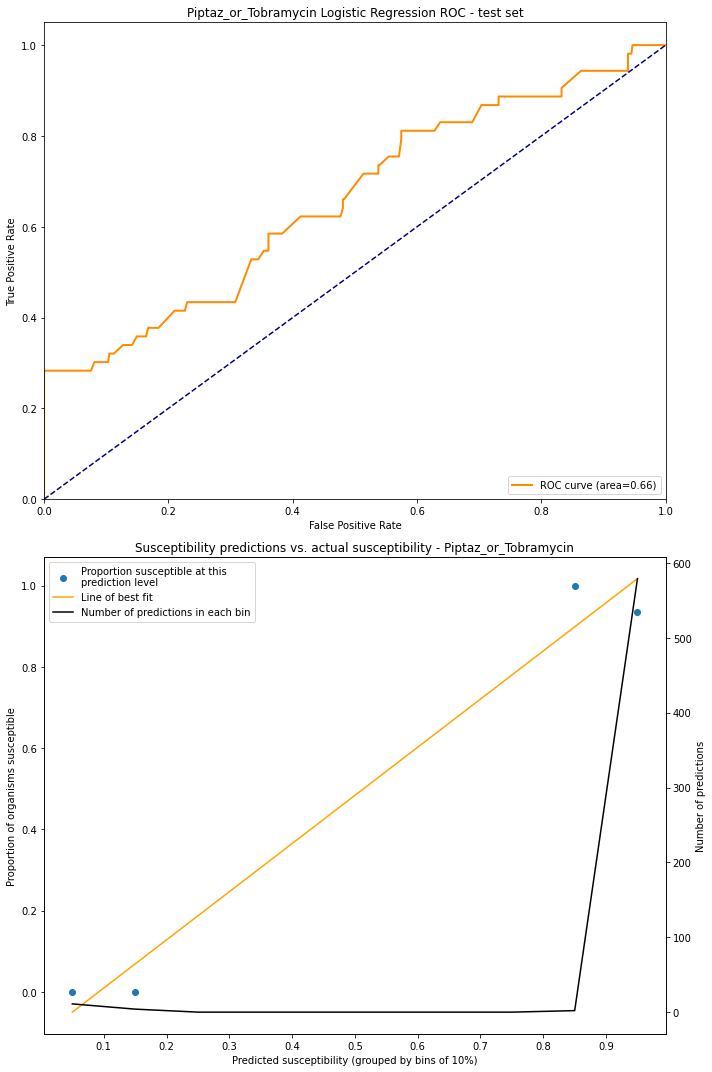

In [16]:
# Combination piperacilliln-tazobactam and tobramycin

antibiotic = 'Piptaz_or_Tobramycin'

# Create a new column based on a multiplication (would only be 1 if both are 1, otherwise 0)
data2019[antibiotic] = (data2019['Piptaz_FINAL_imp'])*(data2019['Tobramycin_FINAL_imp'])

# Add a column for previous susceptibility to pip-tazo and tobramycin
data2019['PriorGNresistance'] = data2019.apply(lambda x: previous_infection(x['PriorGNOrg'],x[antibiotic]), axis=1)

regression_inputs = ['Age','SexCat','Medical(1) Surgical (2) Admitting Service','ClinicalESBL',
                     'RecentHospitalization','ICUExposure',
                     'PriorGNresistance','PriorPenicillin','PriorAMG','PriorNonPenicillin','PriorNonAMG']

# Divide data into temporal 80-20 train-test sets
train_set, test_set= np.split(data2019, [int(.8 *len(data2019))])

X_train = train_set[regression_inputs]
X_test  = test_set [regression_inputs]
Y_train = train_set[antibiotic]
Y_test  = test_set [antibiotic]

reg = linear_model.LogisticRegression()
reg.fit(X_train,Y_train)


# Zip together prediction values and actual test values
# Then sort by susceptible strains first, followed by prediction values
predict_results = sorted((zip(reg.predict_proba(X_test)[:,0],Y_test)),key=lambda x:(x[1],x[0]))

# Separate out predictions on susceptible and resistant isolates
susceptible_isolates = []
resistant_isolates   = []
for i in predict_results:
    if i[1]==1:
        resistant_isolates.append(i[0])
    else: susceptible_isolates.append(i[0])


# Generate plots
fig, ax = plt.subplots(nrows=2, figsize=(10,15))

# Calculate and plot ROC based on training set
fpr, tpr, thresholds = metrics.roc_curve(Y_test,reg.decision_function(X_test))
AUC = metrics.roc_auc_score(Y_test,reg.decision_function(X_test))
ax[0].plot(fpr, tpr, color="darkorange", lw=2,
    label="ROC curve (area={:.2})".format(AUC))

ax[0].plot([0, 1], [0, 1], color="navy", linestyle="--")
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].xaxis.set_tick_params(labelbottom=True)    
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("{} Logistic Regression ROC - test set".format(antibiotic))
ax[0].legend(loc="lower right")


# First, obtain raw prediction or decision function values to create bins
probability_list = [x[0] for x in predict_results]
print('Mean susceptibility: {:.2f}'.format(np.mean(probability_list)))

# Create bins of 0.1 each for later plotting
hist_edges = np.arange(0,1.05,0.1)
bin_medians = np.arange(0.05,1.05,0.1)
bin_susceptibilities = []
bin_counts = [0]*len(bin_medians)

# Then, loop over bins
for i in range(len(hist_edges)-1):

    # Count the number of susceptible and resistant predictions in each bin
    susceptible_number = 0
    resistant_number = 0        
    for j in predict_results:
        if j[0]>=hist_edges[i] and j[0]<hist_edges[i+1]:
            if j[1] == 0: susceptible_number +=1
            if j[1] == 1: resistant_number   +=1
            bin_counts[i] += 1

    # Print and plot observations for each bin
    try:
        percent_susceptible = susceptible_number/(resistant_number+susceptible_number)            
        bin_susceptibilities.append(percent_susceptible)

    except ZeroDivisionError:
        bin_susceptibilities.append(np.nan)


# Plot a scatterplot of binned probabilities and actual susceptibility rates in each bin
ax2a = ax[1]
ax2b = ax[1].twinx()

ax2a.set_title('Susceptibility predictions vs. actual susceptibility - {}'.format(antibiotic))
ax2a.set_xlabel('Predicted susceptibility (grouped by bins of 10%)')
ax2a.set_xticks(np.arange(0,1.1,0.1))
ax2a.set_ylabel('Proportion of organisms susceptible')

# Create a bar chart
ax2b.plot(bin_medians,bin_counts,color='black',label='Number of predictions in each bin')
ax2b.set_ylabel('Number of predictions')

# Create a scatter plot
bin_susceptibilities = np.array(bin_susceptibilities)
ax2a.scatter(bin_medians,bin_susceptibilities,color='C0',label='Proportion susceptible at this\nprediction level')
ax2a.set_yticks(np.arange(0,1.1,0.2))    

# Create a line of best fit
non_nan_indices = np.isfinite(bin_medians) & np.isfinite(bin_susceptibilities)
m,b = np.polyfit(bin_medians[non_nan_indices], bin_susceptibilities[non_nan_indices], 1)
ax2a.plot(bin_medians,m*bin_medians+b,c='orange',label='Line of best fit')    

# Create a legend
lines, labels = ax2a.get_legend_handles_labels()
lines2, labels2 = ax2b.get_legend_handles_labels()
ax2a.legend(lines + lines2, labels + labels2, loc='upper left')

# Delete the bottom right graph and plot the others
plt.tight_layout()
plt.show()